In [1]:
# python standard
import os

# generic data processing
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader

# lightning
import lightning as L
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Project 
from data import *
from plotting import *
from models import *

# Constants
SEED = 654321
MAX_IMAGE_NUM = 21837

In [2]:
# set device variable to cuda or mps if available otherwise cpu
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.empty_cache()
print(device)

cpu


In [3]:
seed_everything(SEED)
BATCH_SIZE = 1

def create_data_directory(path: str):
    if not os.path.exists(path):
        os.makedirs(path)

dir_lightning = os.path.join("..", "lightning", "cnn")
create_data_directory(dir_lightning)

dir_model = os.path.join("..", "models", "unet")
create_data_directory(dir_model)

Seed set to 654321


# Split the Data

Using the stratfold to seperate out the train, validation and test splits

In [4]:
ptbxl_database_df = pd.read_csv("../data/ptb_xl/ptbxl_database.csv")
img_set_df = ptbxl_database_df[['ecg_id', 'strat_fold']]


#define which folds to place in train-val-test sets
train_folds = [1] # 1-8
val_folds = [9] # always 9

# get train-val-test splits of ecg nums
train_id_list, val_id_list, _ = gen_splits(img_set_df, train_folds, val_folds, [])

print(f"train ID length: {len(train_id_list)}")
print(f"val ID length: {len(val_id_list)}")

train ID length: 2175
val ID length: 2183


# Gather Input Data (Predictors)

Cannot use any images that have mismatching bounding boxes and wrong dimensions.  Must discard them from the dataset.  This is handled is proj_utils.py::get_X(). Unknown why the ecg generator is doing this.  The json is recording the correct dimensions but the actual image does not match, nor do the bounding boxes.  Future work.

In [5]:
X_train_df = get_X(train_id_list)
X_train_np = np.stack(X_train_df['img'])
X_train = torch.tensor(X_train_np ).float()
print(f"X_train shape {X_train.shape}")

X_val_df = get_X(val_id_list)
X_val_np = np.stack(X_val_df['img'])
X_val = torch.tensor(X_val_np ).float()
print(f"X_val shape {X_val.shape}")

X_train shape torch.Size([1091, 1, 425, 550])
X_val shape torch.Size([1122, 1, 425, 550])


# Get the Outcome ECG waveforms

Building up the outcomes from left to right across the entire image for each lead.

In [6]:
y_train_np = get_outcomes(X_train_df, "I")
y_train = torch.tensor(y_train_np).float()
print(f"y_train shape: {y_train.shape}")

y_val_np= get_outcomes(X_val_df, "I")
y_val = torch.tensor(y_val_np).float()
print(f"y_val shape: {y_val.shape}")


y_train shape: torch.Size([1091, 5000])
y_val shape: torch.Size([1122, 5000])


# Datasets

In [7]:
train_set = ECGDataSet(X_train, y_train)
print(f"train set shapes X:{train_set.x.shape}, y:{train_set.y.shape}")

val_set = ECGDataSet(X_val, y_val)
print(f"val set shapes X:{val_set.x.shape}, y:{val_set.y.shape}")

train set shapes X:torch.Size([1091, 1, 425, 550]), y:torch.Size([1091, 5000])
val set shapes X:torch.Size([1122, 1, 425, 550]), y:torch.Size([1122, 5000])


# Data Loaders

In [8]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)

# Full CNN Model

In [9]:
class DynamicCNN(nn.Module):
    def __init__(self, input_channels, initial_kernels, num_conv, num_deconv, kernel_size):
        super(DynamicCNN, self).__init__()
                
        # First convolution layer: Use 5000 kernels
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, initial_kernels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(initial_kernels),
            nn.ReLU()
        )
        
        # First loop: Double channels with 3x3 Conv2D, BatchNorm, MaxPool
        self.conv_blocks = nn.ModuleList()
        in_channels = initial_kernels
        out_channels = initial_kernels * 2
        for i in range(num_conv):
            self.conv_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
                    nn.BatchNorm2d(out_channels),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2)
                )
            )
            in_channels = out_channels
            out_channels *= 2  # Double the channels
        
        # Second loop: Halve channels with 1x1 Conv2D
        self.deconv_blocks = nn.ModuleList()
        for i in range(num_deconv):
            self.deconv_blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, in_channels // 2, kernel_size=1),
                    nn.BatchNorm2d(in_channels // 2),
                    nn.ReLU()
                )
            )
            in_channels //= 2  # Half the channels
        
        # # Global max pooling
        self.global_max_pool = nn.AdaptiveMaxPool2d((1, 1))
        
        # # Fully connected layer to produce the desired output size
        # self.fc = nn.Linear(in_channels, desired_output_size)

    def forward(self, x):
        # Pass through the initial convolution layer
        x = self.initial_conv(x)
        
        # Pass through the first loop
        for block in self.conv_blocks:
            x = block(x)
        
        # Pass through the second loop
        for block in self.deconv_blocks:
            x = block(x)
        
        # # Global max pooling
        x = self.global_max_pool(x)
        
        # Flatten to (batch_size, in_channels)
        x = x.view(x.size(0), -1)
        
        # # Pass through the FC layer for the desired output size
        # x = self.fc(x)
        return x


# Example Usage
input_channels = 1
initial_kernels = 128
num_conv = 2
num_deconv = 2
kernel_size=3
encoder = DynamicCNN(input_channels, initial_kernels, num_conv, num_deconv, kernel_size)

# Random input tensor of size (batch_size, channels, height, width)
input_tensor = torch.randn(1, input_channels, 425, 550)
output_features = encoder(input_tensor)

print("Input shape:", input_tensor.shape)
print("Output shape:", output_features.shape)
print("Output shape product:", np.prod(output_features.shape))

Input shape: torch.Size([1, 1, 425, 550])
Output shape: torch.Size([1, 128])
Output shape product: 128


In [10]:
class ECGDecoder(nn.Module):
    def __init__(self, input_dim, num_leads=12, num_lead_samples=5000):
        super().__init__()
        self.flatten = nn.Flatten()  # Flatten the input tensor
        self.linear1 = nn.Linear(input_dim, input_dim)
        self.linear2 = nn.Linear(input_dim, input_dim)
        self.relu = nn.ReLU()
        self.out = nn.Linear(input_dim, num_leads * num_lead_samples)  # Linear layer with 6000 output units
        
    def forward(self, x):
        x = self.flatten(x)  # Flatten the input tensor
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.out(x)   # Pass through the linear layer
        return x

# Test the module with random input data
decoder = ECGDecoder(np.prod(output_features.shape), 1, 5000)
rslt = decoder(output_features)
print(f"Rslt shape: {rslt.shape}")
print(rslt.dtype)

Rslt shape: torch.Size([1, 5000])
torch.float32


In [11]:
# seed_everything(SEED)
model_cnn = ECGRegressor(encoder, decoder)

# training
trainer = L.Trainer(default_root_dir=dir_lightning, 
                max_epochs=10,
                callbacks=[EarlyStopping(monitor="val_loss_epoch_end", mode="min", patience=3)],)
trainer.fit(model=model_cnn, train_dataloaders=train_loader, val_dataloaders=val_loader)


/home/ubuntu/miniconda3/envs/ecg/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: FutureWarning: The default value for `maximize` will be changed from `True` to `None` in v1.7.0 of TorchMetrics,will automatically infer the value based on the `higher_is_better` attribute of the metric (if such attribute exists) or raise an error if it does not. If you are explicitly setting the `maximize` argument to either `True` or `False` already, you can ignore this warning.
  warnings.warn(*args, **kwargs)  # noqa: B028
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/ecg/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVL

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/ubuntu/miniconda3/envs/ecg/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


/home/ubuntu/miniconda3/envs/ecg/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Epoch 0:   0%|          | 0/1091 [00:00<?, ?it/s] 

: 

In [13]:
# save_file_name = "trained_cnn_model.pth"
# save_path = os.path.join(dir_model, save_file_name)

# # Save the trained model's state dictionary to load it later
# torch.save(model_cnn.state_dict(), save_path)
# print(f"Model saved to {save_path}")
# model_cnn.load_state_dict(torch.load(save_path, map_location=torch.device(device)))
# print(f"Model loaded from {save_path}")

Model loaded from ./models/pytorch/cnn/trained_cnn_model.pth


/local_scratch/slurm.1350404/ipykernel_3671426/2979477123.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_cnn.load_state_dict(torch.load(save_path, map_location=to

In [14]:
plot_training_curves(model_cnn)

torch.Size([1, 5000])
torch.Size([1, 5000])


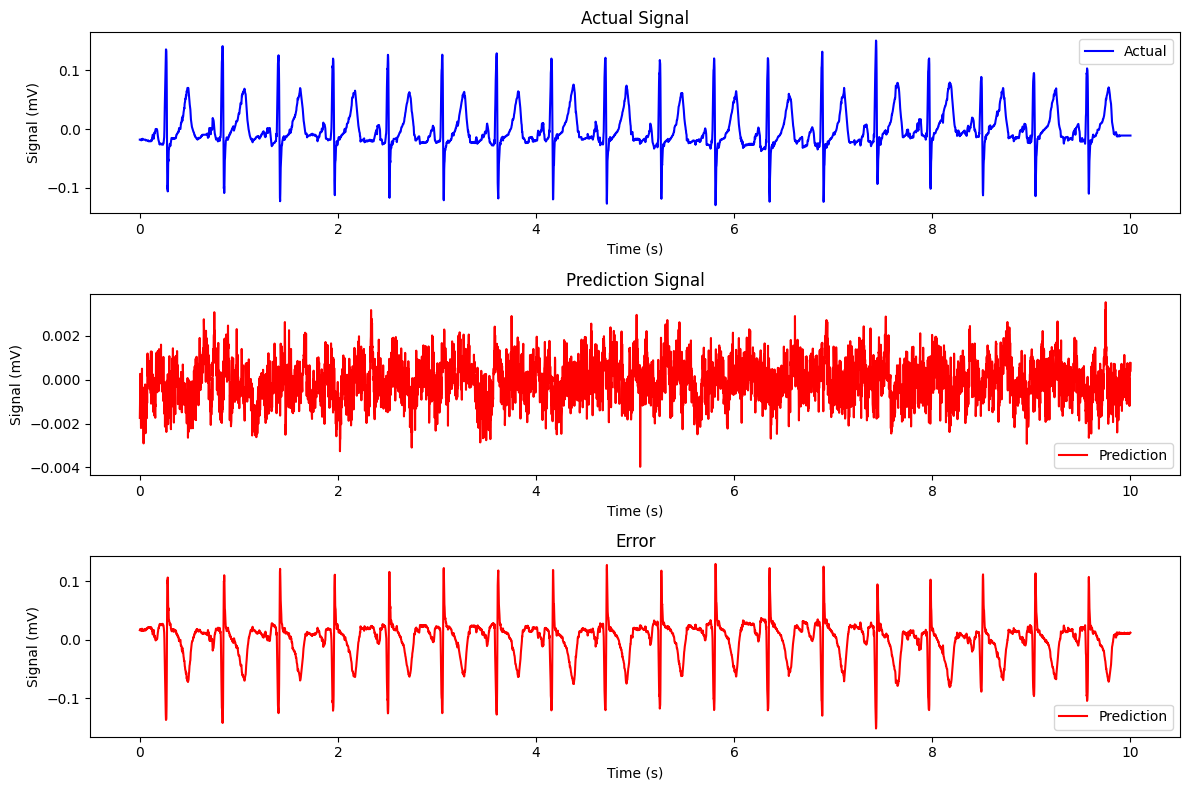

In [15]:
plot_signal_pred(model_cnn, None, val_set)

/home/twgreen/cpsc-4300-6300/project/CPSC4300Project/proj_utils.py:343: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/home/twgreen/cpsc-4300-6300/project/CPSC4300Project/proj_utils.py:344: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/twgreen/.conda/envs/cpsc4300torch/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


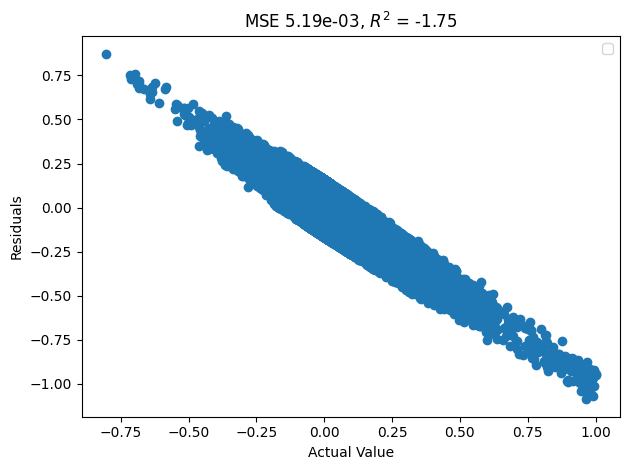

In [16]:
targets = torch.cat(model_cnn.validation_step_targets)
outputs = torch.cat(model_cnn.validation_step_outputs)

plot_residuals(outputs, targets)